In [1]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, ZeroPadding2D, ReLU 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fetch datasets
file_path = r'/kaggle/input/brain-tumor-mri-scans'

In [3]:
def retrieve_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.gif')):
            filepath = os.path.join(directory, filename)
            try:
                img = Image.open(filepath)
                img = img.resize((200, 200), Image.LANCZOS)
                img = img.convert('RGB')
                img = np.asarray(img) / 255.0
                images.append(img)
            except IOError:
                print(f"The file opening error: {filepath}")
    return images

pituitary = retrieve_images(file_path + '/pituitary')
healthy = retrieve_images(file_path + '/healthy')
meningioma = retrieve_images(file_path + '/meningioma')
glioma = retrieve_images(file_path + '/glioma')

In [4]:
# Creatig the Data Frame with image and class
# Classes: healthy : 0, pituitary : 1, meningiona : 2, glioma : 3
healthy_df = pd.DataFrame({
    'image' : healthy,
    'class' : np.full(len(healthy), 0)
})
pituitary_df = pd.DataFrame({
    'image' : pituitary,
    'class' : np.full(len(pituitary), 1)
})
meningiona_df = pd.DataFrame({
    'image' : meningioma,
    'class' : np.full(len(meningioma), 2)
})
glioma_df = pd.DataFrame({
    'image' : glioma,
    'class' : np.full(len(glioma), 3)
})

df = pd.concat([healthy_df, pituitary_df, meningiona_df, glioma_df], ignore_index = True)
df.head()

,image,class
0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0
1,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0
2,"[[[0.0, 0.0, 0.0], [0.0196078431372549, 0.0196...",0
3,"[[[0.7098039215686275, 0.7098039215686275, 0.7...",0
4,"[[[0.4392156862745098, 0.4392156862745098, 0.4...",0


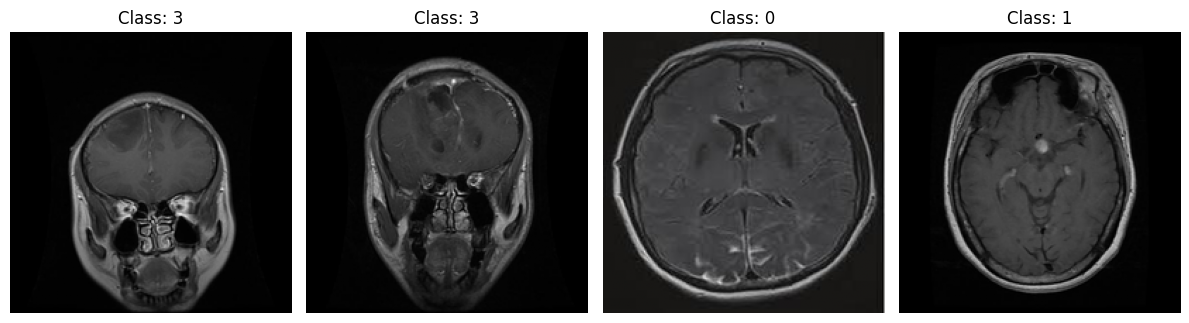

In [5]:
import matplotlib.pyplot as plt
import random

# Function to display random images
def show_random_images(df, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 6))
    random_images = df.sample(num_images)  # Randomly select images
    
    for ax, (_, row) in zip(axes, random_images.iterrows()):
        ax.imshow(row['image'])  # Directly display the numpy array
        ax.set_title(f"Class: {row['class']}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
show_random_images(df)


In [6]:
img_stacked = np.stack(df['image'])
class_array = np.array(df['class'])

print(img_stacked.shape)
print(class_array.shape)

(7023, 200, 200, 3)
(7023,)


In [7]:
train_image, valid_test_image, train_class, valid_test_class = train_test_split(img_stacked, class_array, test_size = 0.2, random_state = 42)
valid_image, test_image, valid_class, test_class = train_test_split(valid_test_image, valid_test_class, test_size = 0.05, random_state = 42)

In [8]:
print(f"Train Image: {train_image.shape}")
print(f"Train Class: {train_class.shape}")
print(f"Valid Image: {valid_image.shape}")
print(f"Valid Class: {valid_class.shape}")
print(f"Test Image: {test_image.shape}")
print(f"Test Class: {test_class.shape}")

Train Image: (5618, 200, 200, 3)
Train Class: (5618,)
Valid Image: (1334, 200, 200, 3)
Valid Class: (1334,)
Test Image: (71, 200, 200, 3)
Test Class: (71,)


In [9]:
# print(train_class[2])
# plt.imshow(train_image[2])

In [10]:
# # Correcting the sets
# train_image = np.stack(train_image)

# valid_image = np.stack(valid_image)

# test_image = np.stack(test_image)

# print(f"Train Image: {train_image.shape}")
# print(f"Train Class: {train_class.shape}")
# print(f"Valid Image: {valid_image.shape}")
# print(f"Valid Class: {valid_class.shape}")
# print(f"Test Image: {test_image.shape}")
# print(f"Test Class: {test_class.shape}")

In [11]:
# Datagenerate for train image
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

train_gen = train_datagen.flow(x = train_image,
                               y = train_class,
                               batch_size = 32,
                              shuffle = True,
                              seed = 42)

# Validation Image Data Generator
valid_datagen = ImageDataGenerator(
    rescale=1.0/255,
)

valid_gen = valid_datagen.flow(
    x=valid_image,
    y = valid_class,
    batch_size=32,
    shuffle=False,  # No shuffling for validation data
    seed=42
)

# Test Image Data Generator
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
)

test_gen = test_datagen.flow(
    x=test_image,
    y = test_class,
    batch_size=32,
    shuffle=False,  # No shuffling for test data
    seed=42
)

In [12]:
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, ReLU, BatchNormalization, MaxPooling2D, ZeroPadding2D, Flatten, Dense, Dropout, Input
# from tensorflow.keras.models import Model

# # Define Input
# input_layer = Input(shape=(200, 200, 3))

# # Convolutional Layer 1
# x = Conv2D(128, (6, 6), strides=(4, 4), padding='valid')(input_layer)
# x = ReLU()(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid')(x)

# # Convolutional Layer 2
# x = ZeroPadding2D(padding=(2, 2))(x)
# x = Conv2D(96, (6, 6), strides=(1, 1), padding='valid')(x)
# x = ReLU()(x)
# x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid')(x)

# # Convolutional Layer 3
# x = ZeroPadding2D(padding=(2, 2))(x)
# x = Conv2D(96, (2, 2), strides=(1, 1), padding='valid')(x)
# x = ReLU()(x)
# x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid')(x)

# # Flatten Layer
# x = Flatten()(x)

# # Fully Connected Layer 1
# x = Dense(512, activation='relu')(x)

# # Dropout Layer
# x = Dropout(0.3)(x)

# # Fully Connected Layer 2 (Output)
# output_layer = Dense(4, activation='softmax')(x)

# # Create the Model
# model = Model(inputs=input_layer, outputs=output_layer)

# # Model Compilation
# model.compile(
#     optimizer = Adam(learning_rate = 1e-3),
#     loss = 'sparse_categorical_crossentropy',
#     metrics = ['accuracy']
# )

# # Summary of Model
# model.summary()

In [13]:
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load EfficientNetB0 model without the top layer
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Make the last 20 layers trainable
for layer in effnet.layers[-20:]:
    layer.trainable = True

# Add custom layers
x = effnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(4, activation='softmax')(x)  # 4 classes

# Create the final model
model = tf.keras.models.Model(inputs=effnet.input, outputs=x)


# Model Compilation
model.compile(
    optimizer = Adam(learning_rate = 1e-3),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

# Summary of Model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 200, 200, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 200, 200, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 200, 200, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 201, 201, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 100, 100, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 100, 100, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 100, 100, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 100, 100, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 100, 100, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 100, 100, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 4,172,032 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [14]:
# Model Fit
train_per_epoch = int(len(train_image) // 32)  # Number of steps per epoch train
valid_per_epoch = int(len(valid_image) // 32) # Numeber of steps per epoch validation

history = model.fit(
    train_gen,
    steps_per_epoch = train_per_epoch,
    validation_data = valid_gen,
    validation_steps = valid_per_epoch,
    epochs=10
)

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 161s 504ms/step - accuracy: 0.6980 - loss: 0.7324 - val_accuracy: 0.3079 - val_loss: 2.4063
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8438 - loss: 0.3883 - val_accuracy: 0.2273 - val_loss: 2.4504
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.8978 - loss: 0.2897 - val_accuracy: 0.3079 - val_loss: 3.1945
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.9375 - loss: 0.2978 - val_accuracy: 0.2273 - val_loss: 3.6056
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 45s 245ms/step - accuracy: 0.9340 - loss: 0.2084 - val_accuracy: 0.3079 - val_loss: 3.7882
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.9688 - loss: 0.0773 - val_accuracy: 0.2273 - val_loss: 4.3932
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 45s 245ms/step - accuracy: 0.9513 - loss: 0.1515 - val_accuracy: 0.3079 - val_loss: 6.4659
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - accuracy: 0.9375 - loss: 0.172

In [15]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.LANCZOS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.LANCZOS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.LANCZOS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    pred = model.predict(ar)
    
    # Get the index of the highest probability
    pred_class = np.argmax(pred, axis=-1)  # This returns the index of the highest probability
    print(pred_class)

    # Map the predicted class to its label
    if pred_class == 0:
        prediction = 'Healthy (No Tumor)'
    elif pred_class == 1:
        prediction = 'Pituitary'
    elif pred_class == 2:
        prediction = 'Meningiona'
    else:
        prediction = 'Glioma'
        
    print(f"Type of tumor: {prediction}")
    return im.resize((300,300), Image.LANCZOS)

In [16]:
pituitary_dir = os.path.join(file_path, 'pituitary')
glioma_dir = os.path.join(file_path, 'glioma')

# List files in the directories
pituitary_files = os.listdir(pituitary_dir)
glioma_files = os.listdir(glioma_dir)

# Select the first image from each directory
img1_name = pituitary_files[0]  # First image in 'pituitary' directory
img2_name = glioma_files[0]    # First image in 'glioma' directory

# Construct full file paths
img1_path = os.path.join(pituitary_dir, img1_name)
img2_path = os.path.join(glioma_dir, img2_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[2]
Type of tumor: Meningiona


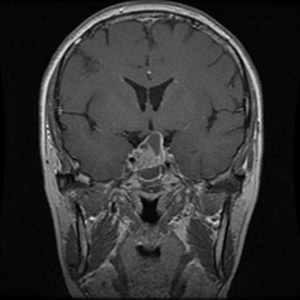

In [17]:
process_and_predict(img1_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[2]
Type of tumor: Meningiona


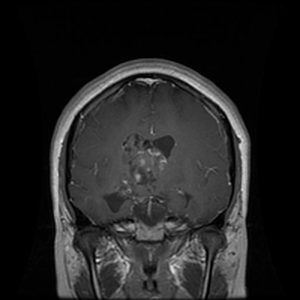

In [18]:
process_and_predict(img2_path)

In [19]:
pd.Series(train_class).unique()

array([1, 2, 0, 3])

In [20]:
model.save('/kaggle/working/my_model.h5')

In [ ]:
p